<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex08/rodrigo_cabrera_castaldoni/Aula_8_Exerc%C3%ADcio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = "Rodrigo Cabrera Castaldoni"
print(f'Meu nome é {nome}')

Meu nome é Rodrigo Cabrera Castaldoni


#  Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da Aula 7, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada. 

Na camada de auto-atenção, não se esqueça de implementar:
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Conexões residuais
- Camada de feed forward (2-layer MLP)



O dataset usado neste exercício (BrWaC) possui um tamanho razoável e você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

In [2]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importação dos pacotes

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook


In [4]:
# Check which GPU we are using
!nvidia-smi

Tue May 24 21:26:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


## Implementação do MyDataset

In [6]:
from typing import List


def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


class MyDataset():
    def __init__(self, texts: List[str], tokenizer, context_size: int):
        self.examples = []
        for text in tqdm_notebook(texts):
            token_ids = tokenize(text=text, tokenizer=tokenizer)
            if len(token_ids) < context_size + 1:
                continue
            # Compute n-grams:
            for i in range(len(token_ids) - context_size):
                input_ids = token_ids[i:i + context_size]
                target_id = token_ids[i + context_size]
                self.examples.append((input_ids, target_id)) 

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        input_ids, target_id = self.examples[idx]
        return torch.LongTensor(input_ids), target_id

## Testando se a implementação do MyDataset está correta

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')

first_batch_input, first_batch_target = next(iter(dummy_loader))

correct_first_batch_input = torch.LongTensor(
    [[ 3396, 10303,   125],
     [ 1660,  5971,   785],
     [ 5971,   785,   125],
     [  785,   125,  1847],
     [  125,  1847, 13779]])

correct_first_batch_target = torch.LongTensor([13239,   125,  1847, 13779, 15616])

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de input')
assert torch.equal(first_batch_target, correct_first_batch_target)
print('Passou no assert de target')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/2 [00:00<?, ?it/s]

passou no assert de tamanho do dataset
Passou no assert de input
Passou no assert de target


# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [8]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt

File ‘sample_brwac.txt’ already there; not retrieving.



In [9]:
# Load datasets
context_size = 9

valid_examples = 100
test_examples = 100
texts = open('sample_brwac.txt').readlines()

print('Truncating for debugging purposes.')
texts = texts#[:500]  

training_texts = texts[:-(valid_examples + test_examples)]
valid_texts = texts[-(valid_examples + test_examples):-test_examples]
test_texts = texts[-test_examples:]

training_dataset = MyDataset(texts=training_texts, tokenizer=tokenizer, context_size=context_size)
valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, context_size=context_size)
test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, context_size=context_size)

Truncating for debugging purposes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/24800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
print(f'training examples: {len(training_dataset)}')
print(f'valid examples: {len(valid_dataset)}')
print(f'test examples: {len(test_dataset)}')

training examples: 27675945
valid examples: 82070
test examples: 166726


Vou utilizar o formato descrito no artigo, denominado post layer normalization. Entretanto não vai ter o último LayerNorm

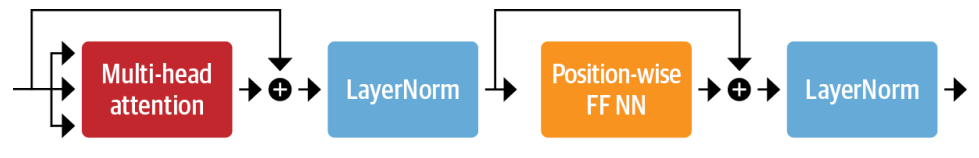

In [11]:
class AttentionHead(torch.nn.Module):

  def __init__(self, embedding_dim, head_dim):
    super(AttentionHead, self).__init__()
    self.head_dim = torch.tensor([head_dim], device=device)
    self.WQ = nn.Linear(embedding_dim, head_dim)
    self.WK = nn.Linear(embedding_dim, head_dim)
    self.WV = nn.Linear(embedding_dim, head_dim)

  def forward(self, inputs):

    keys = self.WK(inputs) # size: (batch_size, num_tokens, head_dim)
    querys = self.WQ(inputs) # size: (batch_size, num_tokens, head_dim)
    values = self.WV(inputs) # size: (batch_size, num_tokens, head_dim)

    # aplica multiplicação matricial em batch 
    scores = torch.bmm(querys, keys.transpose(dim0=1, dim1=2)) / torch.sqrt(self.head_dim) # size: (batch_size, num_tokens, num_tokens)
    weights = torch.nn.functional.softmax(scores, dim=-1) # size: (batch_size, num_tokens, num_tokens); transforma os scores em probas ao longo do último eixo
    attention_scores = torch.bmm(weights, values) # size: (batch_size, num_tokens, head_dim)
    
    return attention_scores

In [12]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, num_attention_heads):
        """
        Implements the Self-attention, decoder-only."

        Args:
            vocab_size (int): Size of the input vocabulary.
            context_size (int): Size of the sequence to consider as context for prediction.
            embedding_dim (int): Dimension of the embedding layer for each word in the context.
        """
        # Escreva seu código aqui.

        super(LanguageModel, self).__init__()

        self.vocab_size = vocab_size
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.num_attention_heads = num_attention_heads
        self.head_dim = self.embedding_dim // self.num_attention_heads

        self.token_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.position_embeddings = nn.Embedding(self.context_size, self.embedding_dim)     
        self.position_ids = torch.arange(self.context_size, dtype=torch.long, device=device).unsqueeze(0)

        self.attentions_heads = nn.ModuleList([AttentionHead(self.embedding_dim, self.head_dim) for _ in range(self.num_attention_heads)])
        self.WO = nn.Linear(self.embedding_dim, self.embedding_dim)

        self.layer_norm_1 = nn.LayerNorm(self.embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(self.embedding_dim)

        self.feed_forward = nn.Sequential(
            torch.nn.Linear(self.context_size*self.embedding_dim, self.embedding_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.embedding_dim, self.vocab_size)
        )

    def forward(self, inputs):
        """
        Args:
            inputs is a LongTensor of shape (batch_size, context_size)
            
        Returns:
            logits of shape (batch_size, vocab_size)
        """
        # Escreva seu código aqui.
        seq_length = inputs.size(1)
        token_embeddings = self.token_embeddings(inputs) 
        position_embeddings = self.position_embeddings(self.position_ids)
        input_embeddings = position_embeddings + token_embeddings
        # No caso em que o numero de cabecas seja multiplo de embedding_dim
        concat_heads = torch.cat([h(input_embeddings) for h in self.attentions_heads], dim=-1) # size: (batch_size, num_tokens, embedding_dim) 
        out = self.layer_norm_1(self.WO(concat_heads) + token_embeddings)
        return self.feed_forward(out.flatten(start_dim=1))


## Teste o modelo com um exemplo

In [13]:
model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=64,
    num_attention_heads=1 # precisa ser multiplo do embedding_dim
).to(device)

sample_train, _ = next(iter(DataLoader(training_dataset, batch_size=4)))
sample_train_gpu = sample_train.to(device)
test = model(sample_train_gpu); test.shape

torch.Size([4, 29794])

In [14]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

Number of model parameters: 3897826


## Assert da Perplexidade


In [15]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)


def perplexity(logits, target):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, vocab_size)
        target: a LongTensor of shape (batch_size,)

    Returns:
        A float corresponding to the perplexity
    """
    loss = nn.functional.cross_entropy(logits, target, reduction='mean')
    return torch.exp(loss)


n_examples = 1000

sample_train, target_token_ids = next(iter(DataLoader(training_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(device)
target_token_ids = target_token_ids.to(device)
logits = model(sample_train_gpu)

my_perplexity = perplexity(logits=logits, target=target_token_ids)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=7000)
print('Passou o no assert da perplexidade')

my perplexity:              30652
correct initial perplexity: 29794
Passou o no assert da perplexidade


## Laço de Treinamento e Validação

In [16]:
max_examples = 100_000_000
eval_every_steps = 5000
lr = 3e-4


model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=128,
    num_attention_heads=16 # precisa ser multiplo do embedding_dim
).to(device)

train_loader = DataLoader(training_dataset, batch_size=256, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=256)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train_step(input, target):
    model.train()
    model.zero_grad()

    logits = model(input.to(device))
    loss = nn.functional.cross_entropy(logits, target.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


def validation_step(input, target):
    model.eval()
    logits = model(input)
    loss = nn.functional.cross_entropy(logits, target)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for input, target in train_loader:
        loss = train_step(input.to(device), target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_ppl = np.exp(np.average(train_losses))

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(input.to(device), target.to(device))
                    for input, target in validation_loader]))

            print(f'{step} steps; {n_examples} examples so far; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []

        n_examples += len(input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

0 steps; 0 examples so far; train ppl: 31150.46, valid ppl: 30341.09
5000 steps; 1280000 examples so far; train ppl: 1150.67, valid ppl: 785.23
10000 steps; 2560000 examples so far; train ppl: 656.32, valid ppl: 572.84
15000 steps; 3840000 examples so far; train ppl: 512.07, valid ppl: 468.12
20000 steps; 5120000 examples so far; train ppl: 432.35, valid ppl: 408.35
25000 steps; 6400000 examples so far; train ppl: 388.96, valid ppl: 372.09
30000 steps; 7680000 examples so far; train ppl: 358.75, valid ppl: 348.47
35000 steps; 8960000 examples so far; train ppl: 336.86, valid ppl: 329.22
40000 steps; 10240000 examples so far; train ppl: 321.51, valid ppl: 317.93
45000 steps; 11520000 examples so far; train ppl: 310.65, valid ppl: 305.71
50000 steps; 12800000 examples so far; train ppl: 301.28, valid ppl: 298.18
55000 steps; 14080000 examples so far; train ppl: 294.78, valid ppl: 290.66
60000 steps; 15360000 examples so far; train ppl: 287.65, valid ppl: 284.66
65000 steps; 16640000 exam

## Avaliação final no dataset de teste


Bonus: o modelo com menor perplexidade no dataset de testes ganhará 0.5 ponto na nota final.

In [17]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input.to(device), target.to(device))
        for input, target in test_loader
    ]))

print(f'test perplexity: {test_ppl}')

test perplexity: 175.91960589924065


## Teste seu modelo com uma sentença

Escolha uma sentença gerada pelo modelo que ache interessante.

In [18]:
prompt = 'Eu gosto de comer pizza pois me faz'
max_output_tokens = 20
model.eval()

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor([input_ids_truncated]).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Eu gosto de comer pizza pois me faz,
Eu gosto de comer pizza pois me faz, mas
Eu gosto de comer pizza pois me faz, mas não
Eu gosto de comer pizza pois me faz, mas não é
Eu gosto de comer pizza pois me faz, mas não é o
Eu gosto de comer pizza pois me faz, mas não é o que
Eu gosto de comer pizza pois me faz, mas não é o que é
Eu gosto de comer pizza pois me faz, mas não é o que é o
Eu gosto de comer pizza pois me faz, mas não é o que é o que
Eu gosto de comer pizza pois me faz, mas não é o que é o que é
Eu gosto de comer pizza pois me faz, mas não é o que é o que é o
Eu gosto de comer pizza pois me faz, mas não é o que é o que é o que
Eu gosto de comer pizza pois me faz, mas não é o que é o que é o que é
Eu gosto de comer pizza pois me faz, mas não é o que é o que é o que é o
Eu gosto de comer pizza pois me faz, mas não é o que é o que é o que é o que
Eu gosto de comer pizza pois me faz, mas não é o que é o que é o que é o que é
Eu gosto de comer pizza pois me faz, mas não é o que é o q